# COMPARING INERTIAL MOTION SENSORS FOR CAPTURING HUMAN MICROMOTION



Authors: Maham Riaz, Finn Upham, Kayla Burnim, Laura Bishop, Alexander Refsum Jensenius

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import json 
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import musicalgestures as mg
from scipy.signal import savgol_filter
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline
import matplotlib.ticker as ticker

## Figure 1

Generating the average image, average motion image, and motiongram from the video recording.

In [ ]:
video = mg.MgVideo('../data/ex1_front.mp4')

Create average image

In [ ]:
video.average()

Run motion analysis to generate motion video, motiongrams, and a motion average image

In [ ]:
video.motion(inverted_motionvideo=True, inverted_motiongram=True).average()

## Figure 3

In [ ]:
video = mg.MgVideo('../data/motion_crop.mp4')

In [ ]:
video.history()

## Figure 4

Plots of accelerometer data from the mobile phone lying still on the floor.

In [123]:
data_phone_liestill = pd.read_csv('../data/ex2_phone_liestill.csv', index_col=0, low_memory=False)

Reading CSV files from [Physics Toolbox Sensor Suite](https://play.google.com/store/apps/dev?id=6483394247866966083&hl=en) by [Vieyra Software](https://www.vieyrasoftware.net/).

In [124]:
# Cutting out part when phone was lying still on the floor
data_floor_liestill = data_phone_liestill.loc[195:325,:].copy()

In [125]:
# The sampling rate is the total number of samples divided by time
sr = len(data_floor_liestill)/(data_floor_liestill.index[-1]-data_floor_liestill.index[0])
sr

18.36028976815679

In [126]:
data_floor_centered = data_floor_liestill.sub(data_floor_liestill.mean())

In [127]:
# Calculate the vector norm
datanorm = np.sqrt(
         data_floor_liestill.gFx ** 2 +
         data_floor_liestill.gFy ** 2 +
         data_floor_liestill.gFz ** 2
    )
# Subtracting the mean to center the values around 0
datanorm_centered = datanorm.sub(datanorm.mean())

In [128]:
#new sampling interval
sr = 20

time_start = data_floor_centered.index[0]
time_end = data_floor_centered.index[-1]
dur = time_end - time_start

time_s = np.round(time_start + np.linspace(0,dur, int(sr*(dur)), endpoint=False),3)

In [129]:
original_data_floor_centered = data_floor_centered.copy()

In [130]:
#resampling
#interpolating the signals to the specified time stamps
cols = data_floor_centered.columns
df_sig = pd.DataFrame(index = time_s,columns = cols)
for c in cols:
    f= interpolate.interp1d(data_floor_centered.index, data_floor_centered[c].values, fill_value = 'extrapolate')
    new_sig = f(time_s)
    df_sig[c] = new_sig
df_sig
data_floor_centered = df_sig.copy()

In [131]:
# Calculate the vector norm again
datanorm = np.sqrt(
         data_floor_centered.gFx ** 2 +
         data_floor_centered.gFy ** 2 +
         data_floor_centered.gFz ** 2
    )
# Subtracting the mean to center the values around 0
datanorm_centered = datanorm.sub(datanorm.mean())

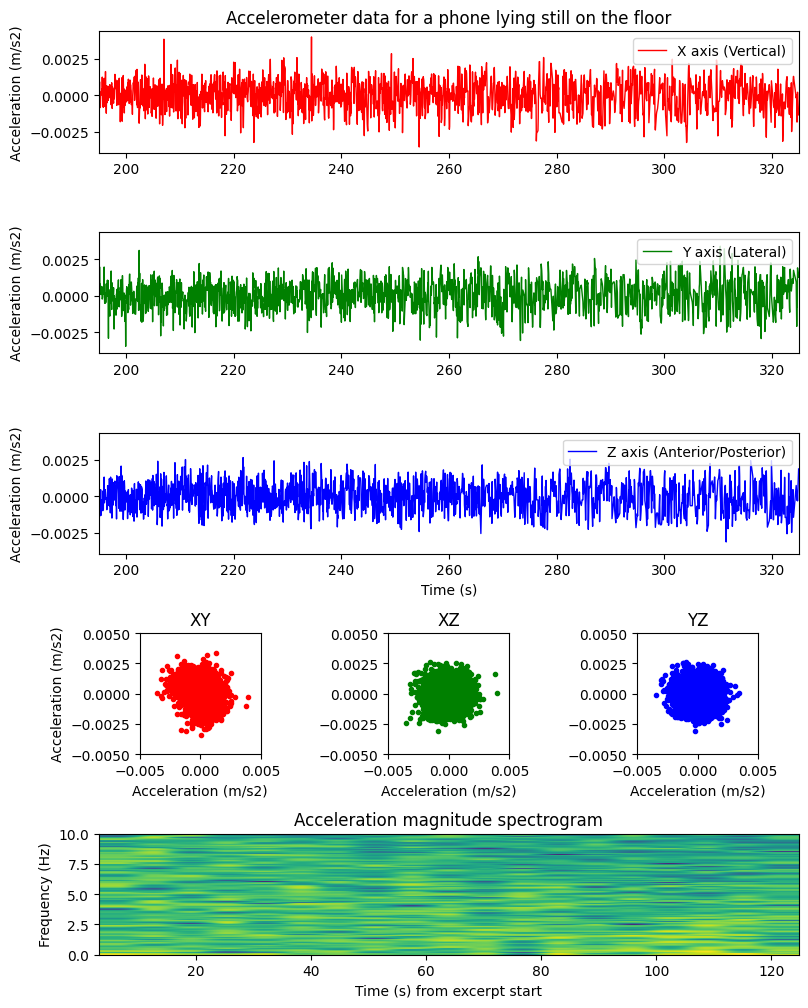

In [132]:
fig = plt.figure(figsize=(8,10))

ax1 = plt.subplot2grid((5, 3), (0, 0), colspan=3)
ax1.plot(data_floor_centered['gFx'], lw=1, label='X axis (Vertical)', color='red')
ax1.legend(loc='upper right')
ax1.set_xlim(time_start, time_end)
plt.ylabel('Acceleration (m/s2)');
plt.title('Accelerometer data for a phone lying still on the floor')

ax2 = plt.subplot2grid((5, 3), (1, 0), colspan=3, sharex=ax1, sharey=ax1)
ax2.plot(data_floor_centered['gFy'], lw=1, label='Y axis (Lateral)', color='green')
ax2.legend(loc='upper right')
plt.ylabel('Acceleration (m/s2)');

ax3 = plt.subplot2grid((5, 3), (2, 0), colspan=3, sharex=ax1, sharey=ax1)
ax3.plot(data_floor_centered['gFz'], lw=1, label='Z axis (Anterior/Posterior)', color='blue')
ax3.legend(loc='upper right')
plt.ylabel('Acceleration (m/s2)');
plt.xlabel('Time (s)');

ax4 = plt.subplot2grid((5, 3), (3, 0))
plt.plot(data_floor_centered['gFx'], data_floor_centered['gFy'], color='red', marker='.', linestyle='') #XY plane
plt.ylabel('Acceleration (m/s2)');
plt.xlabel('Acceleration (m/s2)');
ax4.set_xlim(-0.005, 0.005)
ax4.set_ylim(-0.005, 0.005)
plt.title('XY')
ax4.set_aspect('equal')

ax5 = plt.subplot2grid((5, 3), (3, 1), sharex=ax4, sharey=ax4)
plt.plot(data_floor_centered['gFx'], data_floor_centered['gFz'], color='green', marker='.', linestyle='') #XZ plane
plt.xlabel('Acceleration (m/s2)');
plt.title('XZ')
ax5.set_aspect('equal')

ax6 = plt.subplot2grid((5, 3), (3, 2), sharex=ax4, sharey=ax4)
plt.plot(data_floor_centered['gFy'], data_floor_centered['gFz'], color='blue', marker='.', linestyle='') #ZY plane
plt.xlabel('Acceleration (m/s2)');
plt.title('YZ')
ax6.set_aspect('equal')

ax7 = plt.subplot2grid((5, 3), (4, 0), colspan=3)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(datanorm_centered, Fs=sr)
#ax7.set_ylim(0., 8)
plt.title('Acceleration magnitude spectrogram')

plt.xlabel('Time (s) from excerpt start')
plt.ylabel('Frequency (Hz)')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.savefig("../figures/smc2023_figure4.pdf", bbox_inches='tight', facecolor='white')

## Figure 5 - Phone hanging on person's chest

Plots of accelerometer data from the mobile phone hanging around the neck of a person standing still for 10 minutes.

In [133]:
data_standstill = pd.read_csv('../data/ex2_standstill.csv', index_col=0, low_memory=False)

In [134]:
# The sampling rate is the total number of samples divided by time
sr = len(data_standstill)/(data_standstill.index[-1]-data_standstill.index[0])
sr

16.670885653605353

In [135]:
# Calculate the vector norm
datanorm = np.sqrt(
         data_standstill.gFx ** 2 +
         data_standstill.gFy ** 2 +
         data_standstill.gFz ** 2
    )
# Subtracting the mean to center the values around 0
datanorm_centered = datanorm.sub(datanorm.mean())

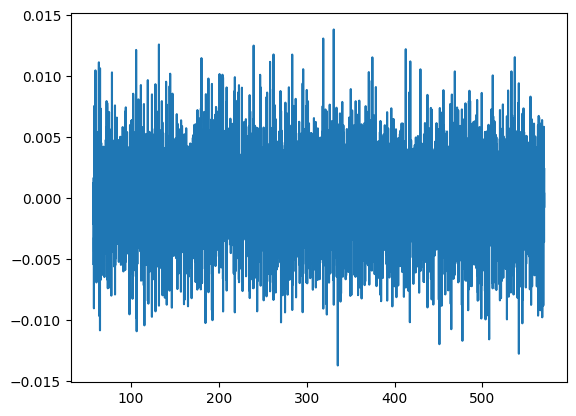

In [136]:
plt.plot(datanorm_centered)

In [137]:
data_standstill_centered = data_standstill.sub(data_standstill.mean())

In [138]:
# Calculate difference between samples
displacement = (np.roll(data_standstill, -1, axis=0) - data_standstill)

# Calculate the vector norm of the displacement
dispnorm = np.sqrt(
         displacement.gFx ** 2 +
         displacement.gFy ** 2 +
         displacement.gFz ** 2
    )
dispnormmean = dispnorm.mean()

In [139]:
#new sampling interval
sr = 16

time_start = data_standstill_centered.index[0]
time_end = data_standstill_centered.index[-1]
dur = time_end - time_start

time_s = np.round(time_start + np.linspace(0,dur, int(sr*(dur)), endpoint=False),3)

In [140]:
original_data_standstill_centered = data_standstill_centered.copy()

In [141]:
#resampling
#interpolating the signals to the specified time stamps
cols = data_standstill_centered.columns
df_sig = pd.DataFrame(index = time_s,columns = cols)
for c in cols:
    f= interpolate.interp1d(data_standstill_centered.index, data_standstill_centered[c].values, fill_value = 'extrapolate')
    new_sig = f(time_s)
    df_sig[c] = new_sig
df_sig
data_standstill_centered = df_sig.copy()

In [142]:
# Calculate the vector norm again
datanorm = np.sqrt(
         data_standstill_centered.gFx ** 2 +
         data_standstill_centered.gFy ** 2 +
         data_standstill_centered.gFz ** 2
    )
# Subtracting the mean to center the values around 0
datanorm_centered = datanorm.sub(datanorm.mean())

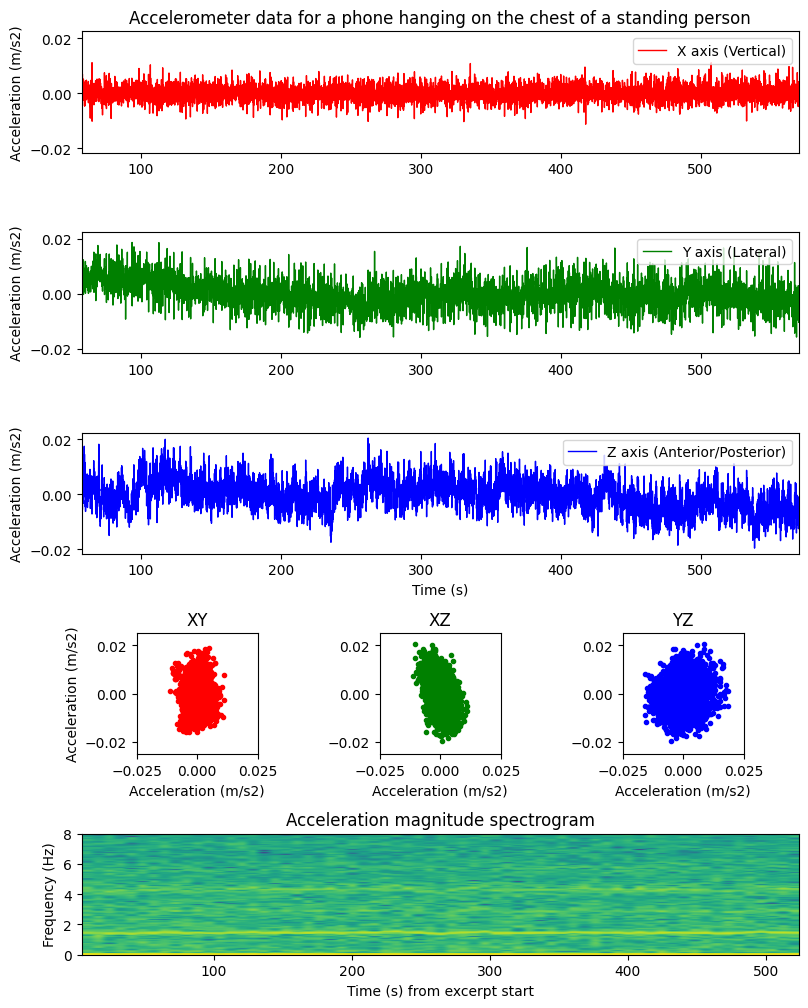

In [145]:
fig = plt.figure(figsize=(8,10))

ax1 = plt.subplot2grid((5, 3), (0, 0), colspan=3)
ax1.plot(data_standstill_centered['gFx'], lw=1, label='X axis (Vertical)', color='red')
ax1.legend(loc='upper right')
ax1.set_xlim(time_start, time_end)
plt.ylabel('Acceleration (m/s2)');
plt.title('Accelerometer data for a phone hanging on the chest of a standing person')

ax2 = plt.subplot2grid((5, 3), (1, 0), colspan=3, sharex=ax1, sharey=ax1)
ax2.plot(data_standstill_centered['gFy'], lw=1, label='Y axis (Lateral)', color='green')
ax2.legend(loc='upper right')
plt.ylabel('Acceleration (m/s2)');

ax3 = plt.subplot2grid((5, 3), (2, 0), colspan=3, sharex=ax1, sharey=ax1)
ax3.plot(data_standstill_centered['gFz'], lw=1, label='Z axis (Anterior/Posterior)', color='blue')
ax3.legend(loc='upper right')
plt.ylabel('Acceleration (m/s2)');
plt.xlabel('Time (s)');

ax4 = plt.subplot2grid((5, 3), (3, 0))
plt.plot(data_standstill_centered['gFx'], data_standstill_centered['gFy'], color='red', marker='.', linestyle='') #XY plane
plt.ylabel('Acceleration (m/s2)');
plt.xlabel('Acceleration (m/s2)');
ax4.set_xlim(-0.025, 0.025)
ax4.set_ylim(-0.025, 0.025)
plt.title('XY')
ax4.set_aspect('equal')

ax5 = plt.subplot2grid((5, 3), (3, 1), sharex=ax4, sharey=ax4)
plt.plot(data_standstill_centered['gFx'], data_standstill_centered['gFz'], color='green', marker='.', linestyle='') #XZ plane
plt.xlabel('Acceleration (m/s2)');
plt.title('XZ')
ax5.set_aspect('equal')

ax6 = plt.subplot2grid((5, 3), (3, 2), sharex=ax4, sharey=ax4)
plt.plot(data_standstill_centered['gFy'], data_standstill_centered['gFz'], color='blue', marker='.', linestyle='') #ZY plane
plt.xlabel('Acceleration (m/s2)');
plt.title('YZ')
ax6.set_aspect('equal')

ax7 = plt.subplot2grid((5, 3), (4, 0), colspan=3)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(dispnorm, Fs=sr)
#ax7.set_ylim(0., 1)
plt.title('Acceleration magnitude spectrogram')

plt.xlabel('Time (s) from excerpt start')
plt.ylabel('Frequency (Hz)')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.savefig("../figures/smc2023_figure5.pdf", bbox_inches='tight', facecolor='white')

## Figure 6

Plots of accelerometer data from the mobile phone hanging around a person's neck performing five different motion sequences.

In [146]:
data_motion = pd.read_csv('../data/ex2_motion.csv', index_col=0, low_memory=False)

In [147]:
# The sampling rate is the total number of samples divided by time
sr = len(data_motion)/(data_motion.index[-1]-data_motion.index[0])
sr

49.86935490423767

In [148]:
# Calculate the vector norm
datanorm = np.sqrt(
         data_motion.gFx ** 2 +
         data_motion.gFy ** 2 +
         data_motion.gFz ** 2
    )
# Subtracting the mean to center the values around 0
datanorm_centered = datanorm.sub(datanorm.mean())

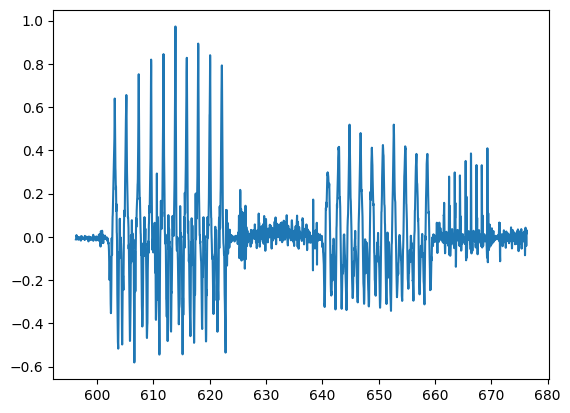

In [149]:
plt.plot(datanorm_centered)

In [150]:
data_motion_centered = data_motion.sub(data_motion.mean())

In [151]:
# Calculate difference between samples
displacement = (np.roll(data_motion_centered, -1, axis=0) - data_motion_centered)

# Calculate the vector norm of the displacement
dispnorm = np.sqrt(
         displacement.gFx ** 2 +
         displacement.gFy ** 2 +
         displacement.gFz ** 2
    )
dispnormmean = dispnorm.mean()

In [152]:
#new sampling interval
sr = 50

time_start = data_motion_centered.index[0]
time_end = data_motion_centered.index[-1]
dur = time_end - time_start

time_s = np.round(time_start + np.linspace(0,dur, int(sr*(dur)), endpoint=False),3)

In [153]:
original_data_motion_centered = data_motion_centered.copy()

In [154]:
#resampling
#interpolating the signals to the specified time stamps
cols = data_motion_centered.columns
df_sig = pd.DataFrame(index = time_s,columns = cols)
for c in cols:
    f= interpolate.interp1d(data_motion_centered.index, data_motion_centered[c].values, fill_value = 'extrapolate')
    new_sig = f(time_s)
    df_sig[c] = new_sig
df_sig
data_motion_centered = df_sig.copy()

In [155]:
# Calculate the vector norm again
datanorm = np.sqrt(
         data_motion_centered.gFx ** 2 +
         data_motion_centered.gFy ** 2 +
         data_motion_centered.gFz ** 2
    )
# Subtracting the mean to center the values around 0
datanorm_centered = datanorm.sub(datanorm.mean())

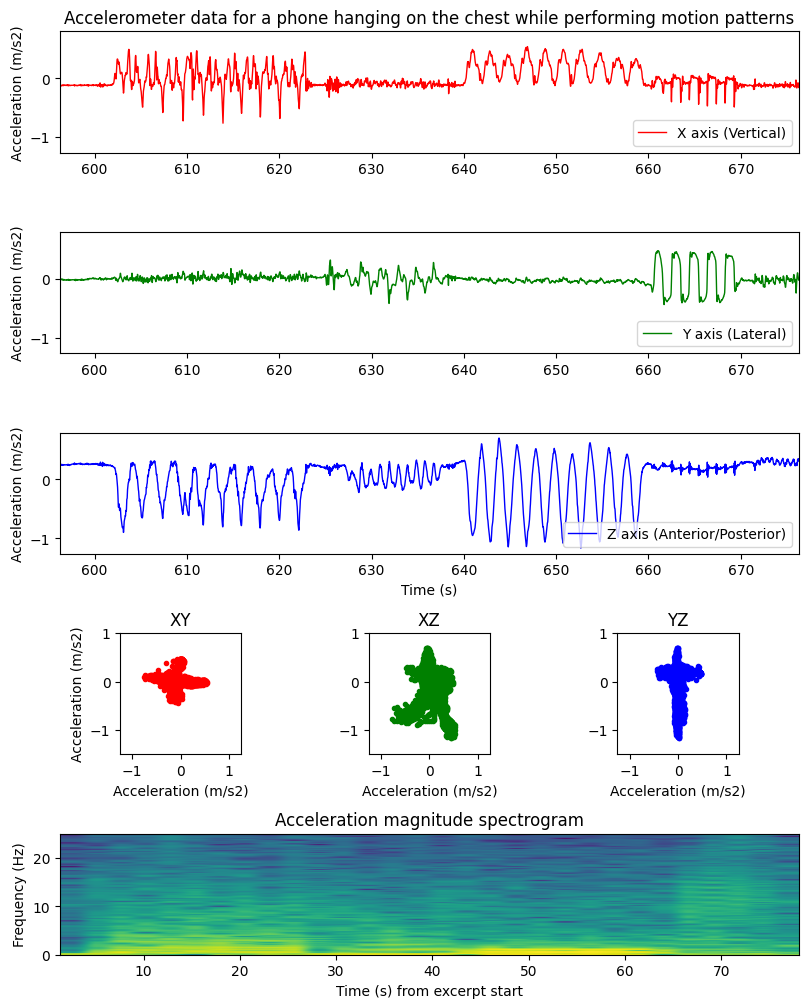

In [156]:
fig = plt.figure(figsize=(8,10))

ax1 = plt.subplot2grid((5, 3), (0, 0), colspan=3)
ax1.plot(data_motion_centered['gFx'], lw=1, label='X axis (Vertical)', color='red')
ax1.legend(loc='lower right')
ax1.set_xlim(time_start, time_end)
plt.ylabel('Acceleration (m/s2)');
plt.title('Accelerometer data for a phone hanging on the chest while performing motion patterns')

ax2 = plt.subplot2grid((5, 3), (1, 0), colspan=3, sharex=ax1, sharey=ax1)
ax2.plot(data_motion_centered['gFy'], lw=1, label='Y axis (Lateral)', color='green')
ax2.legend(loc='lower right')
plt.ylabel('Acceleration (m/s2)');

ax3 = plt.subplot2grid((5, 3), (2, 0), colspan=3, sharex=ax1, sharey=ax1)
ax3.plot(data_motion_centered['gFz'], lw=1, label='Z axis (Anterior/Posterior)', color='blue')
ax3.legend(loc='lower right')
plt.ylabel('Acceleration (m/s2)');
plt.xlabel('Time (s)');

ax4 = plt.subplot2grid((5, 3), (3, 0))
plt.plot(data_motion_centered['gFx'], data_motion_centered['gFy'], color='red', marker='.', linestyle='') #XY plane
plt.ylabel('Acceleration (m/s2)');
plt.xlabel('Acceleration (m/s2)');
ax4.set_xlim(-1.25, 1.25)
ax4.set_ylim(-1.5, 1)
plt.title('XY')
ax4.set_aspect('equal')

ax5 = plt.subplot2grid((5, 3), (3, 1), sharex=ax4, sharey=ax4)
plt.plot(data_motion_centered['gFx'], data_motion_centered['gFz'], color='green', marker='.', linestyle='') #XZ plane
plt.xlabel('Acceleration (m/s2)');
plt.title('XZ')
ax5.set_aspect('equal')

ax6 = plt.subplot2grid((5, 3), (3, 2), sharex=ax4, sharey=ax4)
plt.plot(data_motion_centered['gFy'], data_motion_centered['gFz'], color='blue', marker='.', linestyle='') #ZY plane
plt.xlabel('Acceleration (m/s2)');
plt.title('YZ')
ax6.set_aspect('equal')

ax7 = plt.subplot2grid((5, 3), (4, 0), colspan=3)
ax7.specgram(datanorm_centered, Fs=sr)


plt.title('Acceleration magnitude spectrogram')

plt.xlabel('Time (s) from excerpt start')
plt.ylabel('Frequency (Hz)')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.savefig("../figures/smc2023_figure6.pdf", bbox_inches='tight', facecolor='white')


## Table 1

Average sample rates, dimensional averages and gravity in original device units from four accelerometers during the static floor measurements.

Evaluate the gravity offset for each accelerometer

In [64]:
def min_dets(eq_file_loc): # for files output by the lab manager desktop app, so far
    filings = eq_file_loc.split('/')
    file_name = filings[-1]
    f = file_name.split('.')[0]
    dets = f.split('_')
    sensorType = dets[0]
    start_time= pd.to_datetime(dets[2],format = '%Y%m%dT%H%M%S%f')
    if sensorType in ['Equivital','Movesense']:
        start_time = start_time.tz_localize("UTC")
    if sensorType in ['Phone','AX3']:
        start_time = start_time.tz_localize("Europe/Berlin")
    if sensorType in ['Qualsys']:
        start_time = start_time.tz_localize("EET")
        
    df = pd.read_csv(eq_file_loc,index_col=0) 
    end_time= start_time+ pd.to_timedelta(df['Time'].iloc[-1],unit ='s')
    
    File_dets={'Signal':dets[1], #f[-2].split('_')[-1],
       'Sensor':sensorType, 
       'StartTime':start_time,
       'UTCstartTime':start_time.tz_convert("UTC"),
       'UTCendTime':end_time.tz_convert("UTC"),
       'FileName':file_name,
       'X' :df['X'].mean(),
       'Y' :df['Y'].mean(),
       'Z' :df['Z'].mean(),
       'FullLoc':eq_file_loc}
    return File_dets

In [65]:
path = '../OUTFILES/'
file_locs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if(file.lower().endswith(".csv")):
            file_locs.append(os.path.join(root,file))
            print(file_locs[-1])
k=[]           
for f in file_locs:
    if len(f.split('_'))==3:
        File_dets=min_dets(f)
        k.append(File_dets)
df_files=pd.DataFrame(data=k) #.sort_values('StartTime').reset_index(drop=True)
df_files

../OUTFILES/AX3_ACC_20230131T154908485.csv
../OUTFILES/AX3_ACC_20230203T124319505.csv
../OUTFILES/Equivital_ACC_20230131T143737039.csv
../OUTFILES/Equivital_ACC_20230203T113937039.csv
../OUTFILES/Movesense_ACC_20230131T145727000.csv
../OUTFILES/Movesense_ACC_20230203T114458000.csv
../OUTFILES/Movesense_ACC_20230203T120018000.csv
../OUTFILES/Phone_ACC_20230131T155837000.csv
../OUTFILES/Phone_ACC_20230203T124637000.csv
../OUTFILES/Phone_ACC_20230203T130008000.csv
../OUTFILES/Qualsys_LOC_20230131T165515333.csv


,Signal,Sensor,StartTime,UTCstartTime,UTCendTime,FileName,X,Y,Z,FullLoc
0,ACC,AX3,2023-01-31 15:49:08.485000+01:00,2023-01-31 14:49:08.485000+00:00,2023-01-31 15:13:38.979000+00:00,AX3_ACC_20230131T154908485.csv,1.242981e-01,7.596565e-01,-1.081613e-01,../OUTFILES/AX3_ACC_20230131T154908485.csv
1,ACC,AX3,2023-02-03 12:43:19.505000+01:00,2023-02-03 11:43:19.505000+00:00,2023-02-03 12:09:49.964000+00:00,AX3_ACC_20230203T124319505.csv,7.494074e-02,-4.350857e-01,-3.974312e-01,../OUTFILES/AX3_ACC_20230203T124319505.csv
2,ACC,Equivital,2023-01-31 14:37:37.039000+00:00,2023-01-31 14:37:37.039000+00:00,2023-01-31 15:15:52.300000+00:00,Equivital_ACC_20230131T143737039.csv,6.950539e+01,-2.323754e+02,-8.915916e+02,../OUTFILES/Equivital_ACC_20230131T143737039.csv
3,ACC,Equivital,2023-02-03 11:39:37.039000+00:00,2023-02-03 11:39:37.039000+00:00,2023-02-03 12:06:50.136000+00:00,Equivital_ACC_20230203T113937039.csv,1.140428e+02,1.769141e+02,-6.599488e+02,../OUTFILES/Equivital_ACC_20230203T113937039.csv
4,ACC,Movesense,2023-01-31 14:57:27+00:00,2023-01-31 14:57:27+00:00,2023-01-31 15:09:14.260000+00:00,Movesense_ACC_20230131T145727000.csv,2.331369e-01,9.262575e+00,3.632894e+00,../OUTFILES/Movesense_ACC_20230131T145727000.csv
5,ACC,Movesense,2023-02-03 11:44:58+00:00,2023-02-03 11:44:58+00:00,2023-02-03 11:59:09.338000+00:00,Movesense_ACC_20230203T114458000.csv,-8.791307e-02,-9.316953e+00,2.128527e+00,../OUTFILES/Movesense_ACC_20230203T114458000.csv
6,ACC,Movesense,2023-02-03 12:00:18+00:00,2023-02-03 12:00:18+00:00,2023-02-03 12:06:24.019000+00:00,Movesense_ACC_20230203T120018000.csv,-1.473418e-01,1.018045e-01,9.742499e+00,../OUTFILES/Movesense_ACC_20230203T120018000.csv
7,ACC,Phone,2023-01-31 15:58:37+01:00,2023-01-31 14:58:37+00:00,2023-01-31 15:08:40.720062+00:00,Phone_ACC_20230131T155837000.csv,-9.949474e-01,7.638875e-02,-1.469619e-01,../OUTFILES/Phone_ACC_20230131T155837000.csv
8,ACC,Phone,2023-02-03 12:46:37+01:00,2023-02-03 11:46:37+00:00,2023-02-03 11:58:12.109734+00:00,Phone_ACC_20230203T124637000.csv,-9.900544e-01,5.531115e-02,-6.604025e-02,../OUTFILES/Phone_ACC_20230203T124637000.csv
9,ACC,Phone,2023-02-03 13:00:08+01:00,2023-02-03 12:00:08+00:00,2023-02-03 12:06:08.401004+00:00,Phone_ACC_20230203T130008000.csv,1.320820e-03,-5.855072e-03,1.005977e+00,../OUTFILES/Phone_ACC_20230203T130008000.csv


In [66]:
df_files['Sensor'].unique()

array(['AX3', 'Equivital', 'Movesense', 'Phone', 'Qualsys'], dtype=object)

In [67]:
Time_segments={'floor':['2023-02-03 12:01:00.000000+00:00', '2023-02-03 12:03:00.000000+00:00'],
    'table':['2023-02-03 12:04:00.000000+00:00', '2023-02-03 12:06:00.000000+00:00'],
    'standing1':['2023-01-31 15:00:00.000000+00:00','2023-01-31 15:02:00.000000+00:00'],
    'standing2':['2023-02-03 11:49:00.000000+00:00', '2023-02-03 11:51:00.000000+00:00']}

# '2023-01-31 15:00:00.000000+00:00','2023-01-31 15:02:00.000000+00:00'
# '2023-02-03 11:49:00.000000+00:00', '2023-02-03 11:51:00.000000+00:00'
# '2023-02-03 12:01:00.000000+00:00', '2023-02-03 12:03:00.000000+00:00'
# '2023-02-03 12:04:00.000000+00:00', '2023-02-03 12:06:00.000000+00:00'

In [68]:
Time_segments.keys()

dict_keys(['floor', 'table', 'standing1', 'standing2'])

In [69]:
condition = 'floor'
time_int=Time_segments[condition]
s_time = pd.to_datetime(time_int[0])
e_time = pd.to_datetime(time_int[1])
[s_time,e_time]

[Timestamp('2023-02-03 12:01:00+0000', tz='UTC'),
 Timestamp('2023-02-03 12:03:00+0000', tz='UTC')]

In [70]:
seg_sens = {}
for i,row in df_files.iterrows():
    if row['UTCstartTime']<s_time and row['UTCendTime']>e_time:
        start_time = row['StartTime'].tz_convert("UTC")
        
        df = pd.read_csv(row['FullLoc'],index_col=0)
        df['DateTime'] = start_time + pd.to_timedelta(df['Time'],unit ='s')
        df.set_index(df['DateTime'],inplace=True,drop=True)        
        cols = df.columns
        
        X = df.loc[df.index>s_time,:].copy()
        X = X.loc[X.index<e_time,:].copy()
        seg_sens[row['Sensor']] = X.loc[:,['X', 'Y', 'Z']].copy()

In [71]:
k=[]           

for sensor in ['AX3','Equivital', 'Movesense', 'Phone']:
    clip = seg_sens[sensor]
    qom = np.sqrt(np.square(clip - clip.mean()).sum(axis=1))
    seg_dets={'Signal':sensor,
              'Hz':1/pd.Series(clip.index).diff().mean().total_seconds(),
              'X' :clip['X'].mean(),
              'Y' :clip['Y'].mean(),
              'Z' :clip['Z'].mean(),
              'g': np.sqrt(np.square(clip).sum(axis=1)).mean(),
             }

    k.append(seg_dets)
              
df_segStats=pd.DataFrame(data=k) #.sort_values('StartTime').reset_index(drop=True)
df_segStats

,Signal,Hz,X,Y,Z,g
0,AX3,194.855807,-0.009510,0.000644,-1.010405,1.010485
1,Equivital,25.600328,76.475260,972.411458,-52.803060,976.849969
2,Movesense,210.570646,-0.137610,0.125925,9.741877,9.743707
3,Phone,20.040482,0.001323,-0.008818,1.006006,1.006048


## Table 2

Average (standard deviation, and maximum) samplewise magnitude of change on accelerometer measurements (g = 9.818m/s2) in four devices for 120 s in four conditions. 

Summary of samplewise noise in accelerometers.

The four accelerometers report values in different scales. To get a check on the different scales, we calculate the average total acceleration in the floor recording in each device's reported units. In this condition, the main force acting on each device is gravity. No matter the orientation of the device, the norm of acceleration should equal g, which at 60 degrees near sea level should be about 9.818 m/s^2.

AX3 and Phone appear to normalise the recorded values to g, giving average acceleration of 1, or nearly.

Movesense has g very near the metric units of 9.818 m/s^2. Equivital seemss to have a value close to g but with a factor of 100 to scale acceleration to vary meaningfully within the discrete integer range of +/- 1024 (or similar value).

To make these measurements comparable to other systems, we take normalise the acceleration measurements to actual g for this location.

In [72]:
# from the floor measurements get estimate of gravity constant in the devices units
# The acceleration of gravity in Canada at latitude 60 degrees is approximately 9.818 m/s2, oslo is near 60
# this is used to linearly scale all the clips. 
grav = 9.818 # m/s^2
correction_factor = {'Movesense':9.743707, 'Equivital':976.849969, 'Qualsys':grav*1000, 'AX3':1.010485, 'Phone':1.006048}

In [73]:
df_stats = pd.DataFrame(index = ['AX3','Equivital', 'Movesense', 'Phone'],columns = ['floor','table','standing1','standing2'])

for condition in Time_segments.keys():
    time_int=Time_segments[condition]
    s_time = pd.to_datetime(time_int[0])
    e_time = pd.to_datetime(time_int[1])

    seg_sens = {}
    for i,row in df_files.iterrows():
        if row['UTCstartTime']<s_time and row['UTCendTime']>e_time:
            start_time = row['StartTime'].tz_convert("UTC")
            df = pd.read_csv(row['FullLoc'],index_col=0)
            df['DateTime'] = start_time + pd.to_timedelta(df['Time'],unit ='s')
            df.set_index(df['DateTime'],inplace=True,drop=True)        
            cols = df.columns
            X = df.loc[df.index>s_time,:].copy()
            X = X.loc[X.index<e_time,:].copy()
            clip = grav* X.loc[:,['X', 'Y', 'Z']].copy()/correction_factor[row['Sensor']]
            qom = np.sqrt(np.square(clip.diff()).sum(axis=1)) #np.sqrt(np.square(clip - clip.mean()).sum(axis=1))
            st = qom.mean()
            
            df_stats.loc[row['Sensor'],condition] = str(np.round(qom.mean(),3)) + ' ('+str(np.round(qom.std(),3))+', Mx '+str(np.round(qom.max(),2))+')'

df_stats

,floor,table,standing1,standing2
AX3,"0.124 (0.084, Mx 0.5)","0.094 (0.085, Mx 0.48)","0.085 (0.086, Mx 0.46)","0.103 (0.087, Mx 0.5)"
Equivital,"0.064 (0.029, Mx 0.18)","0.062 (0.029, Mx 0.17)","0.079 (0.037, Mx 0.24)","0.088 (0.045, Mx 0.29)"
Movesense,"0.047 (0.02, Mx 0.16)","0.047 (0.02, Mx 0.16)","0.07 (0.053, Mx 0.71)","0.059 (0.03, Mx 0.24)"
Phone,"0.031 (0.012, Mx 0.15)","0.027 (0.011, Mx 0.06)","0.099 (0.065, Mx 0.4)","0.066 (0.043, Mx 0.35)"
Qualsys,NaN,NaN,"0.0 (0.0, Mx 0.0)",NaN


## Figure 7

Sample-wise Quantity of Motion (normalised to g) for 10 seconds from the four accelerometers in static (floor) and micromotion (standing1) conditions.

In [74]:
Time_segments={'floor':['2023-02-03 12:01:00.000000+00:00', '2023-02-03 12:01:10.000000+00:00'],
    'table':['2023-02-03 12:04:00.000000+00:00', '2023-02-03 12:04:10.000000+00:00'],
    'standing1':['2023-01-31 15:00:00.000000+00:00','2023-01-31 15:00:10.000000+00:00'],
    'standing2':['2023-02-03 11:49:00.000000+00:00', '2023-02-03 11:49:10.000000+00:00']}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


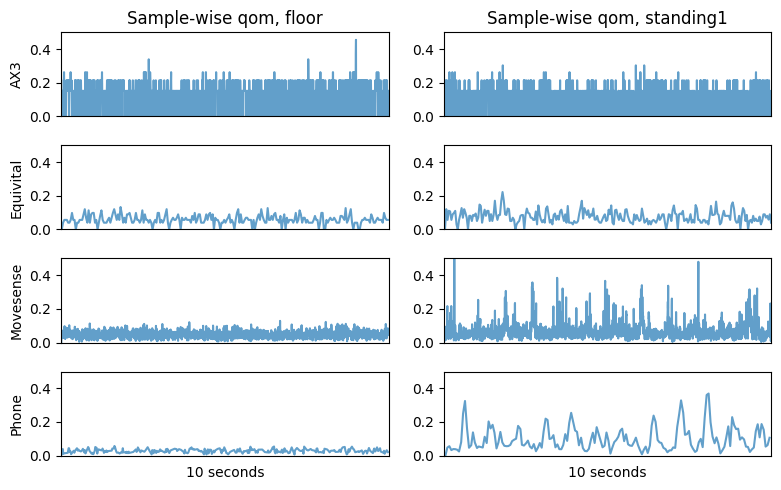

In [75]:
fig, axs = plt.subplots(ncols=2, nrows=4,figsize = [8,5])

sensorList = ['AX3','Equivital', 'Movesense', 'Phone']
conList = ['floor','standing1']
for j in range(len(conList)):
    condition = conList[j]
    time_int=Time_segments[condition]
    s_time = pd.to_datetime(time_int[0])
    e_time = pd.to_datetime(time_int[1])
    seg_sens = {}
    for i,row in df_files.iterrows():
        if row['UTCstartTime']<s_time and row['UTCendTime']>e_time:
            start_time = row['StartTime'].tz_convert("UTC")
            df = pd.read_csv(row['FullLoc'],index_col=0)
            df['DateTime'] = start_time + pd.to_timedelta(df['Time'],unit ='s')
            df['Timestep'] = df['Time'].diff()
            df.set_index(df['DateTime'],inplace=True,drop=True)        
            cols = df.columns

            X = df.loc[df.index>s_time,:].copy()
            X = X.loc[X.index<e_time,:].copy()
            Y = grav* X.loc[:,['X', 'Y', 'Z']].copy()/correction_factor[row['Sensor']]
            Y['Disp'] = np.sqrt(np.square(Y.diff()).sum(axis=1))
            Y['Time'] = X['Time']
            Y['Timestep'] = X['Timestep']
            Y['jerk'] = Y['Disp']/Y['Timestep']
            seg_sens[row['Sensor']] = Y.copy()

    for i  in range(len(sensorList)):
        sensor = sensorList[i]
        clip = seg_sens[sensor]
        #qom = np.sqrt(np.square(clip - clip.mean()).sum(axis=1))
        qom = np.sqrt(np.square(clip.loc[:,['X', 'Y', 'Z']].diff()).sum(axis=1))#/clip['Timestep']
        qom.plot(ax = axs[i,j],alpha = 0.7,label=sensor)

        axs[i,j].set_ylim([0,0.5])
        axs[i,j].set_xticks([])
        axs[i,j].set_xlim([s_time,e_time])
#         axs[i,j].set_yticks([0,0.1,0.2,0.3])
        axs[i,j].set_ylabel(sensor)
        if i == 0:
            axs[i,j].set_title('Sample-wise qom, ' + condition)
        if j == 0:
            axs[i,j].set_ylabel(sensor)
        else:
            axs[i,j].set_ylabel('')
#            axs[i,j].set_yticklabels([])
        if i == 3:
            axs[i,j].set_xlabel('10 seconds')
        else:
            axs[i,j].set_xlabel('')
    
fig.tight_layout()
#samplewise quantity of motion for 2 conditions: floor and standing1
plt.savefig('../figures/smc2023_figure7.eps',format = 'eps',bbox_inches = 'tight',dpi = 300)
plt.show()

## Figure 9

In [157]:
video_data = pd.read_csv('../data/ex1_videoanalysis.csv', index_col=0)
video_data

,Qom,ComX,ComY,AomX1,AomY1,AomX2,AomY2
Time,,,,,,,
0,1126817,0.519861,0.493441,0.638000,0.358333,0.729333,0.630000
40,1126817,0.519861,0.493441,0.638000,0.358333,0.729333,0.630000
80,428770,0.504112,0.485765,0.872000,0.396667,0.894667,0.506667
120,636180,0.514978,0.491081,0.835333,0.410000,0.876000,0.531667
160,572472,0.502318,0.486798,0.870667,0.390000,0.894000,0.600000
...,...,...,...,...,...,...,...
479800,474098,0.483328,0.489409,0.100000,0.606667,0.121333,0.661667
479840,590604,0.494462,0.491481,0.543333,0.370000,0.560000,0.426667
479880,390199,0.477914,0.484960,0.855333,0.510000,0.866000,0.535000


In [158]:
pixels = 600*1500
pixels

900000

In [159]:
video_data.Qom.max()

2153017

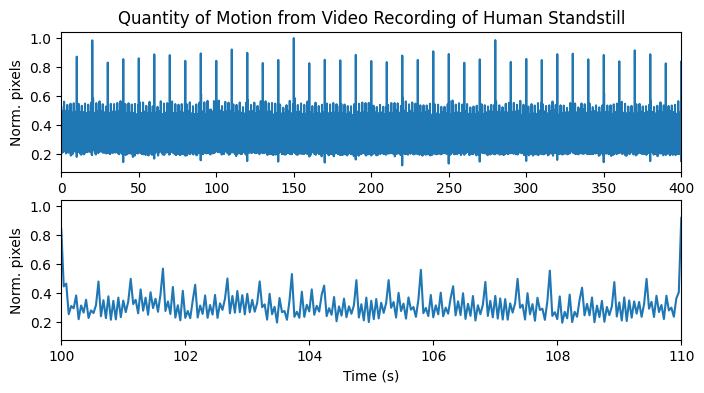

In [160]:
fig = plt.figure(figsize=(8,4))

ax1 = plt.subplot(2, 1, 1)
plt.plot(video_data.index/1000,video_data.Qom/video_data.Qom.max())
ax1.set_xlim(0, 400)
#ax1.set_ylim(0, 10000)

plt.title('Quantity of Motion from Video Recording of Human Standstill')
plt.xlabel('Time (s)')
plt.ylabel('Norm. pixels')

ax2 = plt.subplot(2, 1, 2)

plt.plot(video_data.index/1000,video_data.Qom/video_data.Qom.max())
ax2.set_xlim(100, 110)
#ax2.set_ylim(400000, 1400000)
#ax3.set_aspect('equal')

plt.xlabel('Time (s)')
plt.ylabel('Norm. pixels')

plt.savefig('../figures/smc2023_figure9.pdf', bbox_inches='tight')